# setup and configuration

In [1]:
"""
===============================================================================
TRIAGUARD INSURANCE - SUBROGATION PREDICTION V2
===============================================================================
Goal: Beat 0.59 F1 Score
Strategy: Aggressive feature engineering → Feature selection → Multiple models
===============================================================================
"""

# ============================================================================
# SECTION 1: SETUP & CONFIGURATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

print("✓ Setup complete\n")

✓ Setup complete



# data loading


In [2]:
# ============================================================================
# SECTION 2: DATA LOADING
# ============================================================================

from google.colab import files

print("Upload training data:")
uploaded_train = files.upload()
train_file = list(uploaded_train.keys())[0]

print("\nUpload test data:")
uploaded_test = files.upload()
test_file = list(uploaded_test.keys())[0]

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

print(f"\n✓ Train shape: {train.shape}")
print(f"✓ Test shape: {test.shape}")
print(f"\nTarget distribution:\n{train['subrogation'].value_counts()}")
print(f"Subrogation rate: {train['subrogation'].mean():.2%}")

# Save test IDs for later
test_ids = test['claim_number'].copy()

Upload training data:


Saving Training_TriGuard.csv to Training_TriGuard.csv

Upload test data:


Saving Testing_TriGuard.csv to Testing_TriGuard.csv

✓ Train shape: (18001, 29)
✓ Test shape: (12000, 28)

Target distribution:
subrogation
0.000    13884
1.000     4115
Name: count, dtype: int64
Subrogation rate: 22.86%


# feature engineering


In [3]:
# ============================================================================
# SECTION 3: AGGRESSIVE FEATURE ENGINEERING
# ============================================================================

print("="*80)
print("FEATURE ENGINEERING - CREATING 120+ FEATURES")
print("="*80)

train_fe = train.copy()
test_fe = test.copy()

for df in [train_fe, test_fe]:

    print(f"\nProcessing {'training' if df.shape[0] > 15000 else 'test'} data...")

    # ========================================================================
    # TEMPORAL FEATURES
    # ========================================================================
    df['claim_date'] = pd.to_datetime(df['claim_date'], errors='coerce')
    df['claim_year'] = df['claim_date'].dt.year
    df['claim_month'] = df['claim_date'].dt.month
    df['claim_day'] = df['claim_date'].dt.day
    df['claim_quarter'] = df['claim_date'].dt.quarter
    df['claim_dayofweek'] = df['claim_date'].dt.dayofweek
    df['is_weekend'] = (df['claim_dayofweek'] >= 5).astype(int)
    df['is_monday'] = (df['claim_dayofweek'] == 0).astype(int)
    df['is_friday'] = (df['claim_dayofweek'] == 4).astype(int)
    df['is_q4'] = (df['claim_quarter'] == 4).astype(int)

    # ========================================================================
    # DATA CLEANING
    # ========================================================================
    df.loc[(df['year_of_born'] < 1900) | (df['year_of_born'] > 2025), 'year_of_born'] = np.nan
    future_mask = df['vehicle_made_year'] > df['claim_year']
    df.loc[future_mask, 'vehicle_made_year'] = np.nan

    # ========================================================================
    # TIER 1: CRITICAL INTERACTION FEATURES
    # ========================================================================
    print("  Creating interaction features...")

    # Convert categoricals to binary first for interactions
    df['witness_binary'] = (df['witness_present_ind'] == 'Y').astype(int)
    df['police_binary'] = df['policy_report_filed_ind']
    df['multicar_binary'] = df['accident_type'].isin(['multi_vehicle_clear', 'multi_vehicle_unclear']).astype(int)
    df['highrisk_site_binary'] = df['accident_site'].isin(['Highway/Intersection', 'Local']).astype(int)

    # Key interactions with liability
    df['liab_x_witness'] = df['liab_prct'] * df['witness_binary']
    df['liab_x_police'] = df['liab_prct'] * df['police_binary']
    df['liab_x_multicar'] = df['liab_prct'] * df['multicar_binary']
    df['liab_x_highrisk_site'] = df['liab_prct'] * df['highrisk_site_binary']
    df['liab_x_evidence'] = df['liab_prct'] * (df['witness_binary'] + df['police_binary'])

    # Evidence combinations
    df['witness_x_police'] = df['witness_binary'] * df['police_binary']
    df['witness_x_multicar'] = df['witness_binary'] * df['multicar_binary']
    df['police_x_multicar'] = df['police_binary'] * df['multicar_binary']

    # Accident type x site
    df['multicar_x_highrisk'] = df['multicar_binary'] * df['highrisk_site_binary']

    # ========================================================================
    # TIER 2: POLYNOMIAL FEATURES (LIABILITY)
    # ========================================================================
    print("  Creating polynomial features...")

    df['liab_prct_squared'] = df['liab_prct'] ** 2
    df['liab_prct_cubed'] = df['liab_prct'] ** 3
    df['liab_prct_sqrt'] = np.sqrt(df['liab_prct'])
    df['liab_prct_log'] = np.log1p(df['liab_prct'])
    df['liab_inverse'] = 100 - df['liab_prct']
    df['liab_inverse_squared'] = (100 - df['liab_prct']) ** 2

    # ========================================================================
    # ACCIDENT TYPE FEATURES
    # ========================================================================
    print("  Creating accident type features...")

    df['is_multi_vehicle_clear'] = (df['accident_type'] == 'multi_vehicle_clear').astype(int)
    df['is_multi_vehicle_unclear'] = (df['accident_type'] == 'multi_vehicle_unclear').astype(int)
    df['is_single_car'] = (df['accident_type'] == 'single_car').astype(int)
    df['has_recovery_target'] = df['multicar_binary']

    df['recovery_case_clarity'] = 0
    df.loc[df['is_multi_vehicle_clear'] == 1, 'recovery_case_clarity'] = 3
    df.loc[df['is_multi_vehicle_unclear'] == 1, 'recovery_case_clarity'] = 1

    # ========================================================================
    # LIABILITY BUCKETS (FINE-GRAINED)
    # ========================================================================
    print("  Creating liability buckets...")

    df['liab_under_10'] = (df['liab_prct'] < 10).astype(int)
    df['liab_10_to_15'] = ((df['liab_prct'] >= 10) & (df['liab_prct'] < 15)).astype(int)
    df['liab_15_to_20'] = ((df['liab_prct'] >= 15) & (df['liab_prct'] < 20)).astype(int)
    df['liab_20_to_25'] = ((df['liab_prct'] >= 20) & (df['liab_prct'] < 25)).astype(int)
    df['liab_25_to_30'] = ((df['liab_prct'] >= 25) & (df['liab_prct'] < 30)).astype(int)
    df['liab_30_to_35'] = ((df['liab_prct'] >= 30) & (df['liab_prct'] < 35)).astype(int)
    df['liab_35_to_40'] = ((df['liab_prct'] >= 35) & (df['liab_prct'] < 40)).astype(int)
    df['liab_40_to_50'] = ((df['liab_prct'] >= 40) & (df['liab_prct'] < 50)).astype(int)
    df['liab_over_50'] = (df['liab_prct'] >= 50).astype(int)

    df['not_at_fault'] = df['liab_under_10']
    df['minimal_fault'] = (df['liab_prct'] < 25).astype(int)
    df['low_fault'] = (df['liab_prct'] < 35).astype(int)
    df['shared_fault'] = ((df['liab_prct'] >= 35) & (df['liab_prct'] < 50)).astype(int)
    df['high_fault'] = (df['liab_prct'] >= 50).astype(int)

    # ========================================================================
    # EVIDENCE QUALITY FEATURES
    # ========================================================================
    print("  Creating evidence features...")

    df['witness_present'] = df['witness_binary']
    df['police_report'] = df['police_binary']

    df['evidence_none'] = ((df['witness_present'] == 0) & (df['police_report'] == 0)).astype(int)
    df['evidence_weak'] = (((df['witness_present'] == 1) & (df['police_report'] == 0)) |
                           ((df['witness_present'] == 0) & (df['police_report'] == 1))).astype(int)
    df['evidence_strong'] = ((df['witness_present'] == 1) & (df['police_report'] == 1)).astype(int)
    df['evidence_very_strong'] = ((df['witness_present'] == 1) & (df['police_report'] == 1) &
                                  (df['liab_prct'] < 20)).astype(int)
    df['evidence_score'] = df['witness_present'] + df['police_report']

    # ========================================================================
    # ACCIDENT SITE FEATURES
    # ========================================================================
    print("  Creating site features...")

    df['high_risk_site'] = df['highrisk_site_binary']
    df['parking_accident'] = (df['accident_site'] == 'Parking Area').astype(int)
    df['unknown_site'] = (df['accident_site'] == 'Unknown').astype(int)
    df['highway_accident'] = (df['accident_site'] == 'Highway/Intersection').astype(int)
    df['local_accident'] = (df['accident_site'] == 'Local').astype(int)

    # ========================================================================
    # DRIVER AGE & EXPERIENCE
    # ========================================================================
    print("  Creating driver features...")

    df['driver_age'] = df['claim_year'] - df['year_of_born']
    df.loc[(df['driver_age'] < 16) | (df['driver_age'] > 100), 'driver_age'] = np.nan

    df['young_driver'] = ((df['driver_age'] >= 16) & (df['driver_age'] <= 25)).astype(int)
    df['prime_driver'] = ((df['driver_age'] > 25) & (df['driver_age'] <= 45)).astype(int)
    df['middle_age_driver'] = ((df['driver_age'] > 45) & (df['driver_age'] <= 65)).astype(int)
    df['senior_driver'] = (df['driver_age'] > 65).astype(int)

    df['driving_experience'] = df['driver_age'] - df['age_of_DL']
    df.loc[df['driving_experience'] < 0, 'driving_experience'] = np.nan

    df['novice_driver'] = (df['driving_experience'] < 3).astype(int)
    df['experienced_driver'] = ((df['driving_experience'] >= 3) & (df['driving_experience'] <= 10)).astype(int)
    df['veteran_driver'] = (df['driving_experience'] > 10).astype(int)

    # ========================================================================
    # VEHICLE FEATURES
    # ========================================================================
    print("  Creating vehicle features...")

    df['vehicle_age'] = df['claim_year'] - df['vehicle_made_year']
    df['new_vehicle'] = (df['vehicle_age'] <= 2).astype(int)
    df['mid_age_vehicle'] = ((df['vehicle_age'] > 2) & (df['vehicle_age'] <= 7)).astype(int)
    df['old_vehicle'] = (df['vehicle_age'] > 10).astype(int)

    df['luxury_vehicle'] = (df['vehicle_price'] > 50000).astype(int)
    df['mid_price_vehicle'] = ((df['vehicle_price'] >= 20000) & (df['vehicle_price'] <= 50000)).astype(int)
    df['economy_vehicle'] = (df['vehicle_price'] < 20000).astype(int)

    df['heavy_vehicle'] = (df['vehicle_weight'] > 30000).astype(int)
    df['light_vehicle'] = (df['vehicle_weight'] < 15000).astype(int)

    df['is_large_vehicle'] = (df['vehicle_category'] == 'Large').astype(int)
    df['is_compact_vehicle'] = (df['vehicle_category'] == 'Compact').astype(int)

    # ========================================================================
    # CLAIM CHARACTERISTICS
    # ========================================================================
    print("  Creating claim features...")

    df['high_mileage'] = (df['vehicle_mileage'] > 100000).astype(int)
    df['low_mileage'] = (df['vehicle_mileage'] < 50000).astype(int)
    df['very_high_mileage'] = (df['vehicle_mileage'] > 150000).astype(int)

    df['frequent_claimer'] = (df['past_num_of_claims'] > 5).astype(int)
    df['moderate_claimer'] = ((df['past_num_of_claims'] >= 1) & (df['past_num_of_claims'] <= 5)).astype(int)
    df['first_time_claimer'] = (df['past_num_of_claims'] == 0).astype(int)
    df['very_frequent_claimer'] = (df['past_num_of_claims'] > 10).astype(int)

    df['large_payout'] = (df['claim_est_payout'] > 5000).astype(int)
    df['medium_payout'] = ((df['claim_est_payout'] >= 2000) & (df['claim_est_payout'] <= 5000)).astype(int)
    df['small_payout'] = (df['claim_est_payout'] < 2000).astype(int)
    df['very_large_payout'] = (df['claim_est_payout'] > 8000).astype(int)

    # ========================================================================
    # TIER 4: RATIO FEATURES
    # ========================================================================
    print("  Creating ratio features...")

    df['payout_to_price_ratio'] = df['claim_est_payout'] / (df['vehicle_price'] + 1)
    df['severe_damage'] = (df['payout_to_price_ratio'] > 0.3).astype(int)
    df['moderate_damage'] = ((df['payout_to_price_ratio'] >= 0.1) & (df['payout_to_price_ratio'] <= 0.3)).astype(int)
    df['minor_damage'] = (df['payout_to_price_ratio'] < 0.1).astype(int)

    df['income_to_price_ratio'] = df['annual_income'] / (df['vehicle_price'] + 1)
    df['can_afford_vehicle'] = (df['income_to_price_ratio'] >= 0.5).astype(int)
    df['expensive_for_income'] = (df['income_to_price_ratio'] < 0.3).astype(int)

    df['mileage_per_year'] = df['vehicle_mileage'] / (df['vehicle_age'] + 1)
    df['high_annual_mileage'] = (df['mileage_per_year'] > 15000).astype(int)

    df['claims_per_year_driving'] = df['past_num_of_claims'] / (df['driving_experience'] + 1)
    df['claim_frequency_high'] = (df['claims_per_year_driving'] > 0.5).astype(int)

    df['safety_to_liability'] = df['safety_rating'] / (df['liab_prct'] + 1)
    df['payout_to_income'] = df['claim_est_payout'] / (df['annual_income'] + 1)

    # ========================================================================
    # POLICYHOLDER CHARACTERISTICS
    # ========================================================================
    print("  Creating policyholder features...")

    df['high_income'] = (df['annual_income'] > 70000).astype(int)
    df['mid_income'] = ((df['annual_income'] >= 40000) & (df['annual_income'] <= 70000)).astype(int)
    df['low_income'] = (df['annual_income'] < 40000).astype(int)
    df['very_high_income'] = (df['annual_income'] > 100000).astype(int)

    df['high_safety_rating'] = (df['safety_rating'] > 80).astype(int)
    df['low_safety_rating'] = (df['safety_rating'] < 60).astype(int)
    df['very_high_safety'] = (df['safety_rating'] > 90).astype(int)

    df['contact_available'] = df['email_or_tel_available']
    df['has_education'] = df['high_education_ind']
    df['recent_move'] = df['address_change_ind']
    df['home_owner'] = (df['living_status'] == 'Own').astype(int)
    df['renter'] = (df['living_status'] == 'Rent').astype(int)
    df['female'] = (df['gender'] == 'F').astype(int)

    # ========================================================================
    # CHANNEL FEATURES
    # ========================================================================
    print("  Creating channel features...")

    df['via_broker'] = (df['channel'] == 'Broker').astype(int)
    df['via_online'] = (df['channel'] == 'Online').astype(int)
    df['via_phone'] = (df['channel'] == 'Phone').astype(int)
    df['in_network_repair'] = (df['in_network_bodyshop'] == 'yes').astype(int)

    # ========================================================================
    # TIER 3: COMPOSITE SCORES
    # ========================================================================
    print("  Creating composite scores...")

    # Recovery feasibility score
    liability_score = np.sqrt((100 - df['liab_prct']) / 100.0)
    evidence_score = (df['evidence_none'] * 0.0 + df['evidence_weak'] * 0.4 +
                      df['evidence_strong'] * 0.7 + df['evidence_very_strong'] * 1.0)
    clarity_score = df['recovery_case_clarity'] / 3.0
    site_score = df['high_risk_site'] * 0.7 + (1 - df['unknown_site']) * 0.3

    df['recovery_feasibility_score'] = (0.35 * liability_score + 0.30 * df['has_recovery_target'] +
                                         0.20 * evidence_score + 0.10 * clarity_score + 0.05 * site_score)

    # ========================================================================
    # TIER 3: DOMAIN LOGIC FLAGS
    # ========================================================================
    print("  Creating domain logic flags...")

    df['perfect_case'] = ((df['liab_prct'] < 15) & (df['witness_present'] == 1) &
                          (df['police_report'] == 1) & (df['has_recovery_target'] == 1)).astype(int)

    df['strong_case'] = ((df['liab_prct'] < 25) & (df['evidence_strong'] == 1) &
                         (df['has_recovery_target'] == 1)).astype(int)

    df['good_case'] = ((df['liab_prct'] < 35) & (df['evidence_score'] >= 1) &
                       (df['has_recovery_target'] == 1)).astype(int)

    df['weak_case'] = ((df['liab_prct'] > 40) | (df['is_single_car'] == 1) |
                       (df['evidence_none'] == 1)).astype(int)

    df['no_case'] = ((df['liab_prct'] > 60) | ((df['is_single_car'] == 1) & (df['evidence_none'] == 1))).astype(int)

    df['high_value_opportunity'] = ((df['claim_est_payout'] > 3000) & (df['liab_prct'] < 30) &
                                     (df['has_recovery_target'] == 1)).astype(int)

    df['slam_dunk_case'] = ((df['liab_prct'] < 10) & (df['witness_present'] == 1) &
                            (df['police_report'] == 1) & (df['multicar_binary'] == 1) &
                            (df['high_risk_site'] == 1)).astype(int)

print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETE")
print("="*80)

# Drop target and prepare
train_fe_clean = train_fe.dropna(subset=['subrogation'])

drop_cols = ['subrogation', 'claim_number', 'claim_date', 'year_of_born',
             'witness_present_ind', 'policy_report_filed_ind']

feature_cols = [col for col in train_fe_clean.columns if col not in drop_cols]

X_raw = train_fe_clean[feature_cols].copy()
y = train_fe_clean['subrogation'].copy()
X_test_raw = test_fe[feature_cols].copy()

# Encode categoricals
cat_cols = X_raw.select_dtypes(include='object').columns.tolist()
print(f"\nEncoding {len(cat_cols)} categorical features...")

for col in cat_cols:
    le = LabelEncoder()
    X_raw[col] = le.fit_transform(X_raw[col].astype(str))
    X_test_raw[col] = le.transform(X_test_raw[col].astype(str))

# Fill NaN
X_raw = X_raw.fillna(X_raw.median())
X_test_raw = X_test_raw.fillna(X_test_raw.median())

print(f"\n✓ Total features created: {X_raw.shape[1]}")
print(f"✓ Training samples: {X_raw.shape[0]}")
print(f"✓ Test samples: {X_test_raw.shape[0]}")

FEATURE ENGINEERING - CREATING 120+ FEATURES

Processing training data...
  Creating interaction features...
  Creating polynomial features...
  Creating accident type features...
  Creating liability buckets...
  Creating evidence features...
  Creating site features...
  Creating driver features...
  Creating vehicle features...
  Creating claim features...
  Creating ratio features...
  Creating policyholder features...
  Creating channel features...
  Creating composite scores...
  Creating domain logic flags...

Processing test data...
  Creating interaction features...
  Creating polynomial features...
  Creating accident type features...
  Creating liability buckets...
  Creating evidence features...
  Creating site features...
  Creating driver features...
  Creating vehicle features...
  Creating claim features...
  Creating ratio features...
  Creating policyholder features...
  Creating channel features...
  Creating composite scores...
  Creating domain logic flags...

FEAT

# inital feature selection/filtering


FEATURE SELECTION - FINDING BEST FEATURES

Training initial LightGBM to assess feature importance...
Class weight: 3.37

✓ Feature importance calculated

Top 20 features:
                        feature  importance
11                    liab_prct         379
143  recovery_feasibility_score         329
22              vehicle_mileage         310
18               vehicle_weight         303
124         safety_to_liability         254
7                      zip_code         228
2                 safety_rating         211
117       income_to_price_ratio         190
16                vehicle_price         164
4            high_education_ind         163
25                    claim_day         162
13             claim_est_payout         157
113       payout_to_price_ratio         155
125            payout_to_income         149
87           driving_experience         147
37                liab_x_police         138
10           past_num_of_claims         130
39         liab_x_highrisk_site      

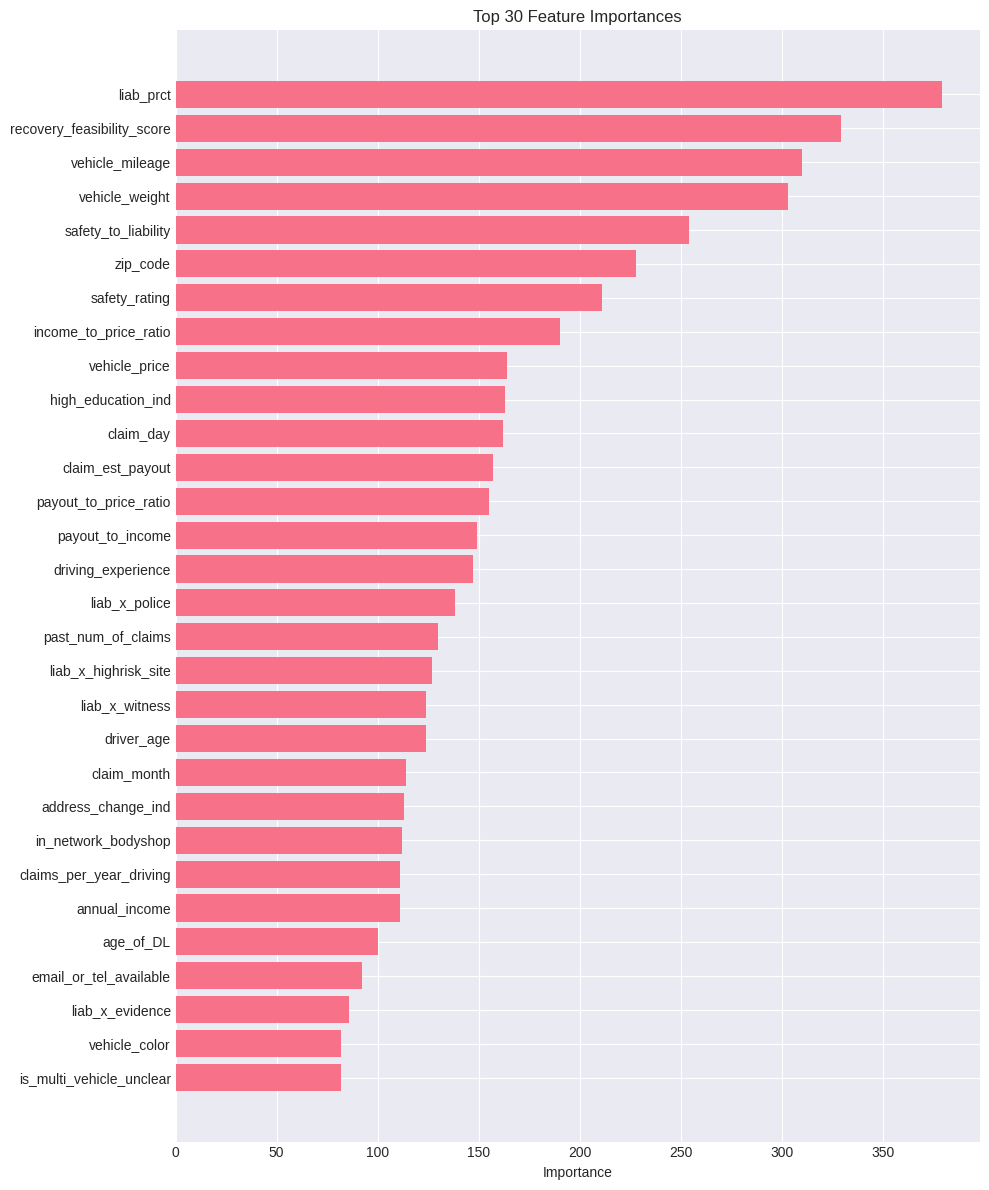


✓ Selecting top 70 features

Selected features:
['liab_prct', 'recovery_feasibility_score', 'vehicle_mileage', 'vehicle_weight', 'safety_to_liability', 'zip_code', 'safety_rating', 'income_to_price_ratio', 'vehicle_price', 'high_education_ind', 'claim_day', 'claim_est_payout', 'payout_to_price_ratio', 'payout_to_income', 'driving_experience', 'liab_x_police', 'past_num_of_claims', 'liab_x_highrisk_site', 'liab_x_witness', 'driver_age', 'claim_month', 'address_change_ind', 'in_network_bodyshop', 'claims_per_year_driving', 'annual_income', 'age_of_DL', 'email_or_tel_available', 'liab_x_evidence', 'vehicle_color', 'is_multi_vehicle_unclear', 'claim_dayofweek', 'liab_x_multicar', 'claim_day_of_week', 'gender', 'mileage_per_year', 'accident_site', 'multicar_x_highrisk', 'witness_x_multicar', 'living_status', 'accident_type', 'witness_binary', 'vehicle_category', 'weak_case', 'is_large_vehicle', 'police_binary', 'parking_accident', 'channel', 'vehicle_made_year', 'liab_inverse', 'is_friday'

In [4]:
# ============================================================================
# SECTION 4: FEATURE SELECTION
# ============================================================================

print("="*80)
print("FEATURE SELECTION - FINDING BEST FEATURES")
print("="*80)

# Train initial model to get feature importances
print("\nTraining initial LightGBM to assess feature importance...")

scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"Class weight: {scale_pos_weight:.2f}")

# Quick model for feature importance
lgb_initial = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgb_initial.fit(X_raw, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_raw.columns,
    'importance': lgb_initial.feature_importances_
}).sort_values('importance', ascending=False)

print("\n✓ Feature importance calculated")
print(f"\nTop 20 features:")
print(feature_importance.head(20))

# Visualize top 30
plt.figure(figsize=(10, 12))
plt.barh(feature_importance.head(30)['feature'], feature_importance.head(30)['importance'])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Select top features
n_features_to_keep = 70
selected_features = feature_importance.head(n_features_to_keep)['feature'].tolist()

print(f"\n✓ Selecting top {n_features_to_keep} features")
print(f"\nSelected features:")
print(selected_features)

# Create datasets with selected features
X_selected = X_raw[selected_features].copy()
X_test_selected = X_test_raw[selected_features].copy()

print(f"\n✓ Feature selection complete!")
print(f"✓ Reduced from {X_raw.shape[1]} to {X_selected.shape[1]} features")
print(f"✓ Feature reduction: {(1 - X_selected.shape[1]/X_raw.shape[1])*100:.1f}%")

# Check for any remaining issues
print(f"\nData quality check:")
print(f"NaNs in X_selected: {X_selected.isnull().sum().sum()}")
print(f"NaNs in X_test_selected: {X_test_selected.isnull().sum().sum()}")
print(f"Inf values in X_selected: {np.isinf(X_selected.values).sum()}")
print(f"Inf values in X_test_selected: {np.isinf(X_test_selected.values).sum()}")

# training models on selected features


In [5]:
# ============================================================================
# SECTION 5: TRAIN MULTIPLE MODELS
# ============================================================================

print("="*80)
print("TRAINING MULTIPLE MODELS ON SELECTED FEATURES")
print("="*80)

# Split for validation (90/10 for more training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.10, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain: {X_train.shape}, Validation: {X_val.shape}")
print(f"Train target: {y_train.value_counts().to_dict()}")
print(f"Val target: {y_val.value_counts().to_dict()}")

models = {}
val_predictions = {}
val_probas = {}

# ============================================================================
# MODEL 1: LightGBM Tuned
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: LightGBM (Tuned)")
print("="*80)

lgb_model = lgb.LGBMClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.03,
    num_leaves=50,
    scale_pos_weight=scale_pos_weight,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgb_model.fit(X_train, y_train)
models['lgb'] = lgb_model

val_probas['lgb'] = lgb_model.predict_proba(X_val)[:, 1]
val_predictions['lgb'] = lgb_model.predict(X_val)

print(f"F1 Score: {f1_score(y_val, val_predictions['lgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, val_probas['lgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val, val_predictions['lgb'])}")

# ============================================================================
# MODEL 2: XGBoost
# ============================================================================

print("\n" + "="*80)
print("MODEL 2: XGBoost")
print("="*80)

xgb_model = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=8,
    learning_rate=0.03,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
models['xgb'] = xgb_model

val_probas['xgb'] = xgb_model.predict_proba(X_val)[:, 1]
val_predictions['xgb'] = xgb_model.predict(X_val)

print(f"F1 Score: {f1_score(y_val, val_predictions['xgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, val_probas['xgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val, val_predictions['xgb'])}")

# ============================================================================
# MODEL 3: Logistic Regression (Your Teammate's Approach)
# ============================================================================

print("\n" + "="*80)
print("MODEL 3: Logistic Regression (Scaled)")
print("="*80)

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lr_model = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='liblinear'
)

lr_model.fit(X_train_scaled, y_train)
models['lr'] = lr_model

val_probas['lr'] = lr_model.predict_proba(X_val_scaled)[:, 1]
val_predictions['lr'] = lr_model.predict(X_val_scaled)

print(f"F1 Score: {f1_score(y_val, val_predictions['lr']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, val_probas['lr']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val, val_predictions['lr'])}")

# ============================================================================
# MODEL COMPARISON
# ============================================================================

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

results = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'Logistic Regression'],
    'F1_Score': [
        f1_score(y_val, val_predictions['lgb']),
        f1_score(y_val, val_predictions['xgb']),
        f1_score(y_val, val_predictions['lr'])
    ],
    'ROC_AUC': [
        roc_auc_score(y_val, val_probas['lgb']),
        roc_auc_score(y_val, val_probas['xgb']),
        roc_auc_score(y_val, val_probas['lr'])
    ]
})

print(results.sort_values('F1_Score', ascending=False))

best_model_name = results.loc[results['F1_Score'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"🏆 Best F1: {results['F1_Score'].max():.4f}")

TRAINING MULTIPLE MODELS ON SELECTED FEATURES

Train: (16199, 70), Validation: (1800, 70)
Train target: {0.0: 12496, 1.0: 3703}
Val target: {0.0: 1388, 1.0: 412}

MODEL 1: LightGBM (Tuned)
F1 Score: 0.5527
ROC AUC: 0.8209

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85      1388
         1.0       0.51      0.60      0.55       412

    accuracy                           0.78      1800
   macro avg       0.69      0.72      0.70      1800
weighted avg       0.79      0.78      0.78      1800


MODEL 2: XGBoost
F1 Score: 0.5461
ROC AUC: 0.8191

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      1388
         1.0       0.55      0.55      0.55       412

    accuracy                           0.79      1800
   macro avg       0.71      0.71      0.71      1800
weighted avg       0.79      0.79      0.79      1800


MODEL 3: Logistic Regres

# training models on all features

In [6]:
# ============================================================================
# SECTION 6: MODELS ON ALL FEATURES (NO SELECTION)
# ============================================================================

print("="*80)
print("TRAINING MODELS ON ALL 151 FEATURES")
print("="*80)

# Use same 90/10 split
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
    X_raw, y, test_size=0.10, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain: {X_train_all.shape}, Validation: {X_val_all.shape}")

models_all = {}
val_predictions_all = {}
val_probas_all = {}

# ============================================================================
# MODEL 1: LightGBM on ALL features
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: LightGBM (All 151 Features)")
print("="*80)

lgb_all = lgb.LGBMClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.03,
    num_leaves=50,
    scale_pos_weight=scale_pos_weight,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgb_all.fit(X_train_all, y_train_all)
models_all['lgb'] = lgb_all

val_probas_all['lgb'] = lgb_all.predict_proba(X_val_all)[:, 1]
val_predictions_all['lgb'] = lgb_all.predict(X_val_all)

print(f"F1 Score: {f1_score(y_val_all, val_predictions_all['lgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_all, val_probas_all['lgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_all, val_predictions_all['lgb'])}")

# ============================================================================
# MODEL 2: XGBoost on ALL features
# ============================================================================

print("\n" + "="*80)
print("MODEL 2: XGBoost (All 151 Features)")
print("="*80)

xgb_all = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=8,
    learning_rate=0.03,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

xgb_all.fit(X_train_all, y_train_all)
models_all['xgb'] = xgb_all

val_probas_all['xgb'] = xgb_all.predict_proba(X_val_all)[:, 1]
val_predictions_all['xgb'] = xgb_all.predict(X_val_all)

print(f"F1 Score: {f1_score(y_val_all, val_predictions_all['xgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_all, val_probas_all['xgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_all, val_predictions_all['xgb'])}")

# ============================================================================
# MODEL 3: Logistic Regression on ALL features
# ============================================================================

print("\n" + "="*80)
print("MODEL 3: Logistic Regression (All 151 Features, Scaled)")
print("="*80)

scaler_all = StandardScaler()
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
X_val_all_scaled = scaler_all.transform(X_val_all)

lr_all = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='liblinear'
)

lr_all.fit(X_train_all_scaled, y_train_all)
models_all['lr'] = lr_all

val_probas_all['lr'] = lr_all.predict_proba(X_val_all_scaled)[:, 1]
val_predictions_all['lr'] = lr_all.predict(X_val_all_scaled)

print(f"F1 Score: {f1_score(y_val_all, val_predictions_all['lr']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_all, val_probas_all['lr']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_all, val_predictions_all['lr'])}")

# ============================================================================
# COMPARISON: 70 Features vs 151 Features
# ============================================================================

print("\n" + "="*80)
print("COMPARISON: 70 SELECTED vs 151 ALL FEATURES")
print("="*80)

comparison = pd.DataFrame({
    'Model': ['LightGBM (70)', 'XGBoost (70)', 'LogReg (70)',
              'LightGBM (151)', 'XGBoost (151)', 'LogReg (151)'],
    'F1_Score': [
        f1_score(y_val, val_predictions['lgb']),
        f1_score(y_val, val_predictions['xgb']),
        f1_score(y_val, val_predictions['lr']),
        f1_score(y_val_all, val_predictions_all['lgb']),
        f1_score(y_val_all, val_predictions_all['xgb']),
        f1_score(y_val_all, val_predictions_all['lr'])
    ],
    'ROC_AUC': [
        roc_auc_score(y_val, val_probas['lgb']),
        roc_auc_score(y_val, val_probas['xgb']),
        roc_auc_score(y_val, val_probas['lr']),
        roc_auc_score(y_val_all, val_probas_all['lgb']),
        roc_auc_score(y_val_all, val_probas_all['xgb']),
        roc_auc_score(y_val_all, val_probas_all['lr'])
    ]
})

print(comparison.sort_values('F1_Score', ascending=False))

print(f"\n🏆 BEST OVERALL: {comparison.loc[comparison['F1_Score'].idxmax(), 'Model']}")
print(f"🏆 Best F1: {comparison['F1_Score'].max():.4f}")

TRAINING MODELS ON ALL 151 FEATURES

Train: (16199, 151), Validation: (1800, 151)

MODEL 1: LightGBM (All 151 Features)
F1 Score: 0.5656
ROC AUC: 0.8185

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      1388
         1.0       0.53      0.61      0.57       412

    accuracy                           0.79      1800
   macro avg       0.70      0.72      0.71      1800
weighted avg       0.80      0.79      0.79      1800


MODEL 2: XGBoost (All 151 Features)
F1 Score: 0.5610
ROC AUC: 0.8225

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      1388
         1.0       0.56      0.56      0.56       412

    accuracy                           0.80      1800
   macro avg       0.72      0.72      0.72      1800
weighted avg       0.80      0.80      0.80      1800


MODEL 3: Logistic Regression (All 151 Features, Scaled)
F1 Score: 0.5750
R

# all feature, 0.7/0.3 split


In [7]:
# ============================================================================
# SECTION 7: MODELS WITH 70/30 SPLIT (RELIABLE VALIDATION)
# ============================================================================

print("="*80)
print("TRAINING WITH 70/30 SPLIT FOR RELIABLE VALIDATION")
print("="*80)

# 70/30 split
X_train_70, X_val_30, y_train_70, y_val_30 = train_test_split(
    X_raw, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain: {X_train_70.shape}, Validation: {X_val_30.shape}")
print(f"Train target: {y_train_70.value_counts().to_dict()}")
print(f"Val target: {y_val_30.value_counts().to_dict()}")

models_70 = {}
val_predictions_70 = {}
val_probas_70 = {}

# ============================================================================
# MODEL 1: LightGBM
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: LightGBM (70/30 split, 151 features)")
print("="*80)

lgb_70 = lgb.LGBMClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.03,
    num_leaves=50,
    scale_pos_weight=scale_pos_weight,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgb_70.fit(X_train_70, y_train_70)
models_70['lgb'] = lgb_70

val_probas_70['lgb'] = lgb_70.predict_proba(X_val_30)[:, 1]
val_predictions_70['lgb'] = lgb_70.predict(X_val_30)

print(f"F1 Score: {f1_score(y_val_30, val_predictions_70['lgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_30, val_probas_70['lgb']):.4f}")
print(f"PR AUC: {average_precision_score(y_val_30, val_probas_70['lgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_30, val_predictions_70['lgb'])}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val_30, val_predictions_70['lgb'])}")

# ============================================================================
# MODEL 2: XGBoost
# ============================================================================

print("\n" + "="*80)
print("MODEL 2: XGBoost (70/30 split, 151 features)")
print("="*80)

xgb_70 = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=8,
    learning_rate=0.03,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

xgb_70.fit(X_train_70, y_train_70)
models_70['xgb'] = xgb_70

val_probas_70['xgb'] = xgb_70.predict_proba(X_val_30)[:, 1]
val_predictions_70['xgb'] = xgb_70.predict(X_val_30)

print(f"F1 Score: {f1_score(y_val_30, val_predictions_70['xgb']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_30, val_probas_70['xgb']):.4f}")
print(f"PR AUC: {average_precision_score(y_val_30, val_probas_70['xgb']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_30, val_predictions_70['xgb'])}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val_30, val_predictions_70['xgb'])}")

# ============================================================================
# MODEL 3: Logistic Regression
# ============================================================================

print("\n" + "="*80)
print("MODEL 3: Logistic Regression (70/30 split, 151 features, scaled)")
print("="*80)

scaler_70 = StandardScaler()
X_train_70_scaled = scaler_70.fit_transform(X_train_70)
X_val_30_scaled = scaler_70.transform(X_val_30)

lr_70 = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='liblinear'
)

lr_70.fit(X_train_70_scaled, y_train_70)
models_70['lr'] = lr_70

val_probas_70['lr'] = lr_70.predict_proba(X_val_30_scaled)[:, 1]
val_predictions_70['lr'] = lr_70.predict(X_val_30_scaled)

print(f"F1 Score: {f1_score(y_val_30, val_predictions_70['lr']):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_30, val_probas_70['lr']):.4f}")
print(f"PR AUC: {average_precision_score(y_val_30, val_probas_70['lr']):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val_30, val_predictions_70['lr'])}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val_30, val_predictions_70['lr'])}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: 70/30 SPLIT RESULTS")
print("="*80)

summary = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'Logistic Regression'],
    'F1_Score': [
        f1_score(y_val_30, val_predictions_70['lgb']),
        f1_score(y_val_30, val_predictions_70['xgb']),
        f1_score(y_val_30, val_predictions_70['lr'])
    ],
    'ROC_AUC': [
        roc_auc_score(y_val_30, val_probas_70['lgb']),
        roc_auc_score(y_val_30, val_probas_70['xgb']),
        roc_auc_score(y_val_30, val_probas_70['lr'])
    ],
    'PR_AUC': [
        average_precision_score(y_val_30, val_probas_70['lgb']),
        average_precision_score(y_val_30, val_probas_70['xgb']),
        average_precision_score(y_val_30, val_probas_70['lr'])
    ]
})

print(summary.sort_values('F1_Score', ascending=False))

print(f"\n🏆 Best Model: {summary.loc[summary['F1_Score'].idxmax(), 'Model']}")
print(f"🏆 Best F1: {summary['F1_Score'].max():.4f}")
print(f"\n📊 Validation size: {X_val_30.shape[0]} samples (30%)")
print(f"📊 This is a MORE RELIABLE estimate than 10% validation")

TRAINING WITH 70/30 SPLIT FOR RELIABLE VALIDATION

Train: (12599, 151), Validation: (5400, 151)
Train target: {0.0: 9719, 1.0: 2880}
Val target: {0.0: 4165, 1.0: 1235}

MODEL 1: LightGBM (70/30 split, 151 features)
F1 Score: 0.5456
ROC AUC: 0.8120
PR AUC: 0.5483

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.86      4165
         1.0       0.52      0.58      0.55      1235

    accuracy                           0.78      5400
   macro avg       0.69      0.71      0.70      5400
weighted avg       0.79      0.78      0.78      5400

Confusion Matrix:
[[3502  663]
 [ 523  712]]

MODEL 2: XGBoost (70/30 split, 151 features)
F1 Score: 0.5335
ROC AUC: 0.8137
PR AUC: 0.5500

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86      4165
         1.0       0.53      0.54      0.53      1235

    accuracy                           0.78      5400
   ma

# section split ------

# working on lightgbm

In [8]:
# ============================================================================
# STEP 1: TARGET ENCODING FOR LIGHTGBM
# ============================================================================

print("="*80)
print("STEP 1: ADDING TARGET ENCODING")
print("="*80)

# Identify categorical features
cat_features_for_encoding = ['accident_site', 'accident_type', 'channel',
                              'vehicle_category', 'vehicle_color', 'living_status',
                              'claim_day_of_week', 'gender', 'in_network_bodyshop']

# Create copy of data
train_fe_v2 = train_fe.copy()
test_fe_v2 = test_fe.copy()

# Clean train
train_fe_v2_clean = train_fe_v2.dropna(subset=['subrogation'])

print(f"Creating target encodings for {len(cat_features_for_encoding)} categorical features...")

# Calculate target encoding (mean subrogation rate per category)
for col in cat_features_for_encoding:
    # Calculate mean subrogation rate per category from training data
    target_mean = train_fe_v2_clean.groupby(col)['subrogation'].mean()
    global_mean = train_fe_v2_clean['subrogation'].mean()

    # Apply to train (with smoothing to avoid overfitting)
    category_counts = train_fe_v2_clean.groupby(col).size()
    smoothing = 10  # smoothing factor
    smoothed_mean = (target_mean * category_counts + global_mean * smoothing) / (category_counts + smoothing)

    train_fe_v2_clean[f'{col}_target_enc'] = train_fe_v2_clean[col].map(smoothed_mean)

    # Apply to test (use training stats)
    test_fe_v2[f'{col}_target_enc'] = test_fe_v2[col].map(smoothed_mean).fillna(global_mean)

    print(f"  ✓ {col}: {len(target_mean)} categories encoded")

print(f"\n✓ Target encoding complete!")

# Rebuild feature matrix
drop_cols = ['subrogation', 'claim_number', 'claim_date', 'year_of_born',
             'witness_present_ind', 'policy_report_filed_ind']

feature_cols_v2 = [col for col in train_fe_v2_clean.columns if col not in drop_cols]

X_v2 = train_fe_v2_clean[feature_cols_v2].copy()
y_v2 = train_fe_v2_clean['subrogation'].copy()
X_test_v2 = test_fe_v2[feature_cols_v2].copy()

# Encode remaining categoricals
cat_cols_v2 = X_v2.select_dtypes(include='object').columns.tolist()
print(f"\nEncoding {len(cat_cols_v2)} remaining categorical features...")

for col in cat_cols_v2:
    le = LabelEncoder()
    X_v2[col] = le.fit_transform(X_v2[col].astype(str))
    X_test_v2[col] = le.transform(X_test_v2[col].astype(str))

# Fill NaN
X_v2 = X_v2.fillna(X_v2.median())
X_test_v2 = X_test_v2.fillna(X_test_v2.median())

print(f"\n✓ New feature count: {X_v2.shape[1]} (was 151)")

# Split for validation
X_train_v2, X_val_v2, y_train_v2, y_val_v2 = train_test_split(
    X_v2, y_v2, test_size=0.30, random_state=RANDOM_STATE, stratify=y_v2
)

print(f"✓ Train: {X_train_v2.shape}, Val: {X_val_v2.shape}")

# ============================================================================
# TEST: LightGBM with Target Encoding
# ============================================================================

print("\n" + "="*80)
print("TESTING: LightGBM with Target Encoding")
print("="*80)

lgb_v2 = lgb.LGBMClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.03,
    num_leaves=50,
    scale_pos_weight=scale_pos_weight,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgb_v2.fit(X_train_v2, y_train_v2)
y_val_pred_v2 = lgb_v2.predict(X_val_v2)
y_val_proba_v2 = lgb_v2.predict_proba(X_val_v2)[:, 1]

print(f"\nF1 Score: {f1_score(y_val_v2, y_val_pred_v2):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_v2, y_val_proba_v2):.4f}")
print(f"PR AUC: {average_precision_score(y_val_v2, y_val_proba_v2):.4f}")

print(f"\nClassification Report:\n{classification_report(y_val_v2, y_val_pred_v2)}")

# Compare to baseline
print(f"\n{'='*80}")
print(f"COMPARISON")
print(f"{'='*80}")
print(f"Baseline LightGBM (151 features):     F1 = 0.5456")
print(f"LightGBM + Target Encoding:           F1 = {f1_score(y_val_v2, y_val_pred_v2):.4f}")
print(f"Improvement:                           +{f1_score(y_val_v2, y_val_pred_v2) - 0.5456:.4f}")

if f1_score(y_val_v2, y_val_pred_v2) > 0.5456:
    print("\n✅ IMPROVEMENT! Target encoding helps.")
else:
    print("\n❌ No improvement. May need different approach.")

STEP 1: ADDING TARGET ENCODING
Creating target encodings for 9 categorical features...
  ✓ accident_site: 4 categories encoded
  ✓ accident_type: 3 categories encoded
  ✓ channel: 3 categories encoded
  ✓ vehicle_category: 3 categories encoded
  ✓ vehicle_color: 7 categories encoded
  ✓ living_status: 2 categories encoded
  ✓ claim_day_of_week: 7 categories encoded
  ✓ gender: 2 categories encoded
  ✓ in_network_bodyshop: 2 categories encoded

✓ Target encoding complete!

Encoding 9 remaining categorical features...

✓ New feature count: 160 (was 151)
✓ Train: (12599, 160), Val: (5400, 160)

TESTING: LightGBM with Target Encoding

F1 Score: 0.5508
ROC AUC: 0.8110
PR AUC: 0.5425

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85      4165
         1.0       0.52      0.59      0.55      1235

    accuracy                           0.78      5400
   macro avg       0.70      0.71      0.70      5400
weighted avg     

STEP 2: OPTUNA HYPERPARAMETER OPTIMIZATION
Installing Optuna...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.8 MB/s eta 0:00:00
✓ Optuna installed

Running Optuna optimization (50 trials, ~5-10 minutes)...
This will test 50 different parameter combinations...



  0%|          | 0/50 [00:00<?, ?it/s]


OPTIMIZATION COMPLETE

🏆 Best F1 Score: 0.5706
🏆 Improvement over baseline: +0.0250
🏆 Improvement over target encoding: +0.0198

📊 Best Parameters:
  n_estimators: 864
  learning_rate: 0.01180364122878554
  num_leaves: 77
  max_depth: 5
  min_child_samples: 24
  subsample: 0.6440543874528366
  colsample_bytree: 0.784340210736604
  reg_alpha: 0.1475355558711881
  reg_lambda: 0.13377640991084788

TRAINING FINAL MODEL WITH BEST PARAMETERS

Tuned LightGBM Performance:
F1 Score: 0.5706
ROC AUC: 0.8217
PR AUC: 0.5709

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82      4165
         1.0       0.47      0.73      0.57      1235

    accuracy                           0.75      5400
   macro avg       0.69      0.74      0.70      5400
weighted avg       0.80      0.75      0.76      5400


Confusion Matrix:
[[3133 1032]
 [ 330  905]]

PROGRESS SUMMARY
Baseline LightGBM:           0.5456
+ Target Encoding:           0.

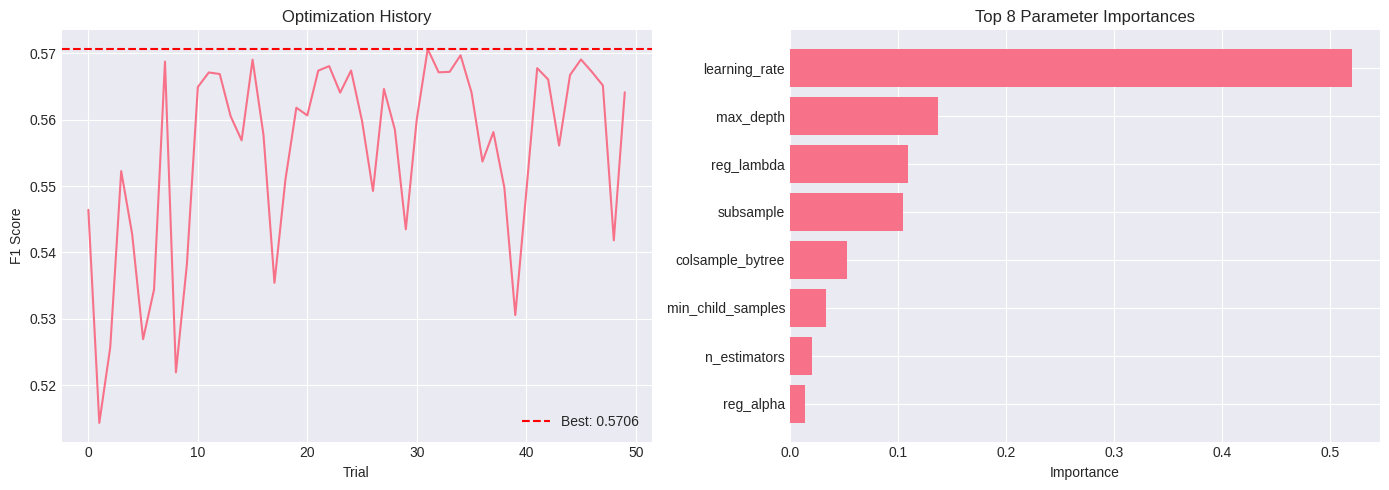


✓ Optuna tuning complete!


In [9]:
# ============================================================================
# STEP 2: OPTUNA HYPERPARAMETER TUNING FOR LIGHTGBM
# ============================================================================

print("="*80)
print("STEP 2: OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*80)

# Install optuna if needed
try:
    import optuna
    print("✓ Optuna available")
except:
    print("Installing Optuna...")
    !pip install optuna
    import optuna
    print("✓ Optuna installed")

# Suppress optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_v2, y_train_v2)
    preds = model.predict(X_val_v2)

    return f1_score(y_val_v2, preds)

# Run optimization
print("\nRunning Optuna optimization (50 trials, ~5-10 minutes)...")
print("This will test 50 different parameter combinations...\n")

study = optuna.create_study(direction='maximize', study_name='lgb_f1_optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\n{'='*80}")
print("OPTIMIZATION COMPLETE")
print(f"{'='*80}")

print(f"\n🏆 Best F1 Score: {study.best_value:.4f}")
print(f"🏆 Improvement over baseline: +{study.best_value - 0.5456:.4f}")
print(f"🏆 Improvement over target encoding: +{study.best_value - 0.5508:.4f}")

print(f"\n📊 Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Train final model with best parameters
print(f"\n{'='*80}")
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print(f"{'='*80}")

best_params = study.best_params.copy()
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['verbose'] = -1

lgb_tuned = lgb.LGBMClassifier(**best_params)
lgb_tuned.fit(X_train_v2, y_train_v2)

y_val_pred_tuned = lgb_tuned.predict(X_val_v2)
y_val_proba_tuned = lgb_tuned.predict_proba(X_val_v2)[:, 1]

print(f"\nTuned LightGBM Performance:")
print(f"F1 Score: {f1_score(y_val_v2, y_val_pred_tuned):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_v2, y_val_proba_tuned):.4f}")
print(f"PR AUC: {average_precision_score(y_val_v2, y_val_proba_tuned):.4f}")

print(f"\nClassification Report:\n{classification_report(y_val_v2, y_val_pred_tuned)}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_val_v2, y_val_pred_tuned)}")

# Progress summary
print(f"\n{'='*80}")
print("PROGRESS SUMMARY")
print(f"{'='*80}")
print(f"Baseline LightGBM:           0.5456")
print(f"+ Target Encoding:           0.5508 (+0.0052)")
print(f"+ Optuna Tuning:             {f1_score(y_val_v2, y_val_pred_tuned):.4f} (+{f1_score(y_val_v2, y_val_pred_tuned) - 0.5508:.4f})")
print(f"Total Improvement:           +{f1_score(y_val_v2, y_val_pred_tuned) - 0.5456:.4f}")

# Visualize optimization history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 score history
axes[0].plot([trial.value for trial in study.trials])
axes[0].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Optimization History')
axes[0].legend()
axes[0].grid(True)

# Parameter importance
try:
    importance = optuna.importance.get_param_importances(study)
    params_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:8]
    param_names = [p[0] for p in params_sorted]
    param_vals = [p[1] for p in params_sorted]

    axes[1].barh(param_names, param_vals)
    axes[1].set_xlabel('Importance')
    axes[1].set_title('Top 8 Parameter Importances')
    axes[1].invert_yaxis()
except:
    axes[1].text(0.5, 0.5, 'Parameter importance\nnot available',
                ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

print(f"\n✓ Optuna tuning complete!")

STEP 3: 5-FOLD CROSS-VALIDATION

Running 5-Fold Cross-Validation with best parameters...
This validates performance across 5 different train/val splits

Fold 1/5...
  F1: 0.5825 | ROC: 0.8403 | PR: 0.5957
Fold 2/5...
  F1: 0.5721 | ROC: 0.8235 | PR: 0.5870
Fold 3/5...
  F1: 0.5861 | ROC: 0.8406 | PR: 0.5833
Fold 4/5...
  F1: 0.5774 | ROC: 0.8389 | PR: 0.5981
Fold 5/5...
  F1: 0.5829 | ROC: 0.8291 | PR: 0.5728

CROSS-VALIDATION RESULTS
 Fold    F1  ROC_AUC  PR_AUC  Precision  Recall
    1 0.582    0.840   0.596      0.472   0.759
    2 0.572    0.824   0.587      0.459   0.759
    3 0.586    0.841   0.583      0.484   0.742
    4 0.577    0.839   0.598      0.472   0.744
    5 0.583    0.829   0.573      0.477   0.750

SUMMARY STATISTICS
Mean F1:      0.5802
Std F1:       0.0049
Min F1:       0.5721
Max F1:       0.5861
95% CI:       [0.5705, 0.5898]


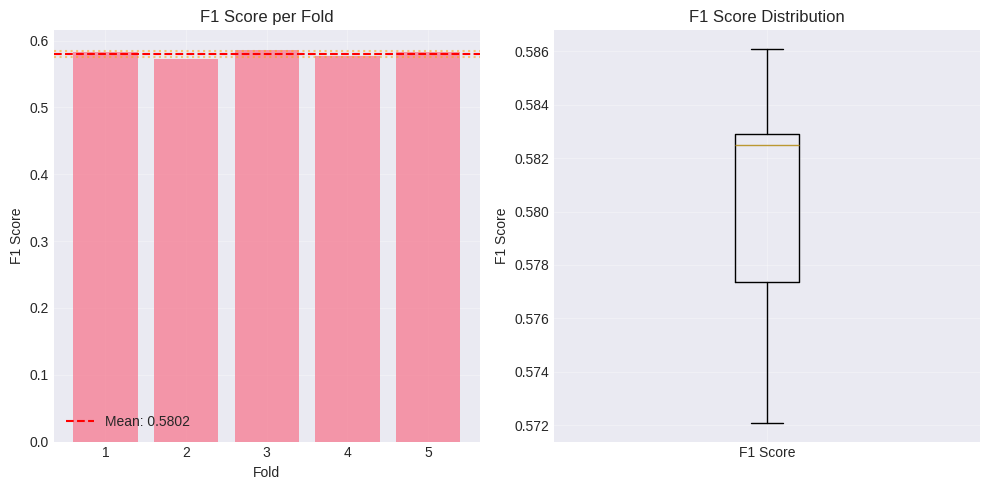


INTERPRETATION
Single 70/30 split F1:      0.5706
5-Fold CV Mean F1:          0.5802
Difference:                 +0.0096

✅ Low variance (0.0049) - model is STABLE!

🎯 Expected Leaderboard F1: 0.5802 ± 0.0049


In [10]:
# ============================================================================
# STEP 3: 5-FOLD CROSS-VALIDATION WITH BEST PARAMETERS
# ============================================================================

print("="*80)
print("STEP 3: 5-FOLD CROSS-VALIDATION")
print("="*80)

from sklearn.model_selection import StratifiedKFold

# Use best parameters from Optuna
best_params_cv = study.best_params.copy()
best_params_cv['scale_pos_weight'] = scale_pos_weight
best_params_cv['random_state'] = RANDOM_STATE
best_params_cv['verbose'] = -1

# Setup 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f"\nRunning 5-Fold Cross-Validation with best parameters...")
print(f"This validates performance across 5 different train/val splits\n")

fold_scores = []
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_v2, y_v2), 1):
    print(f"Fold {fold}/5...")

    X_train_fold = X_v2.iloc[train_idx]
    y_train_fold = y_v2.iloc[train_idx]
    X_val_fold = X_v2.iloc[val_idx]
    y_val_fold = y_v2.iloc[val_idx]

    # Train model
    model_fold = lgb.LGBMClassifier(**best_params_cv)
    model_fold.fit(X_train_fold, y_train_fold)

    # Predict
    y_pred_fold = model_fold.predict(X_val_fold)
    y_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]

    # Calculate metrics
    f1 = f1_score(y_val_fold, y_pred_fold)
    roc = roc_auc_score(y_val_fold, y_proba_fold)
    pr = average_precision_score(y_val_fold, y_proba_fold)
    precision = precision_score(y_val_fold, y_pred_fold)
    recall = recall_score(y_val_fold, y_pred_fold)

    fold_scores.append(f1)
    fold_results.append({
        'Fold': fold,
        'F1': f1,
        'ROC_AUC': roc,
        'PR_AUC': pr,
        'Precision': precision,
        'Recall': recall
    })

    print(f"  F1: {f1:.4f} | ROC: {roc:.4f} | PR: {pr:.4f}")

# Calculate statistics
mean_f1 = np.mean(fold_scores)
std_f1 = np.std(fold_scores)
min_f1 = np.min(fold_scores)
max_f1 = np.max(fold_scores)

print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*80}")

results_df = pd.DataFrame(fold_results)
print(results_df.to_string(index=False))

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"Mean F1:      {mean_f1:.4f}")
print(f"Std F1:       {std_f1:.4f}")
print(f"Min F1:       {min_f1:.4f}")
print(f"Max F1:       {max_f1:.4f}")
print(f"95% CI:       [{mean_f1 - 1.96*std_f1:.4f}, {mean_f1 + 1.96*std_f1:.4f}]")

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, 6), fold_scores, alpha=0.7)
plt.axhline(y=mean_f1, color='r', linestyle='--', label=f'Mean: {mean_f1:.4f}')
plt.axhline(y=mean_f1 + std_f1, color='orange', linestyle=':', alpha=0.5)
plt.axhline(y=mean_f1 - std_f1, color='orange', linestyle=':', alpha=0.5)
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score per Fold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(fold_scores, labels=['F1 Score'])
plt.ylabel('F1 Score')
plt.title('F1 Score Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("INTERPRETATION")
print(f"{'='*80}")
print(f"Single 70/30 split F1:      0.5706")
print(f"5-Fold CV Mean F1:          {mean_f1:.4f}")
print(f"Difference:                 {mean_f1 - 0.5706:+.4f}")

if std_f1 < 0.01:
    print(f"\n✅ Low variance ({std_f1:.4f}) - model is STABLE!")
elif std_f1 < 0.02:
    print(f"\n✅ Moderate variance ({std_f1:.4f}) - model is reasonably stable")
else:
    print(f"\n⚠️  High variance ({std_f1:.4f}) - model performance varies by data split")

print(f"\n🎯 Expected Leaderboard F1: {mean_f1:.4f} ± {std_f1:.4f}")

STEP 3: 5-FOLD CROSS-VALIDATION (with Accuracy)

Running 5-Fold Cross-Validation with best parameters...
This validates performance across 5 different train/val splits

Fold 1/5...
  Accuracy: 0.7511 | F1: 0.5825 | ROC: 0.8403 | PR: 0.5957
Fold 2/5...
  Accuracy: 0.7403 | F1: 0.5721 | ROC: 0.8235 | PR: 0.5870
Fold 3/5...
  Accuracy: 0.7603 | F1: 0.5861 | ROC: 0.8406 | PR: 0.5833
Fold 4/5...
  Accuracy: 0.7511 | F1: 0.5774 | ROC: 0.8389 | PR: 0.5981
Fold 5/5...
  Accuracy: 0.7547 | F1: 0.5829 | ROC: 0.8291 | PR: 0.5728

CROSS-VALIDATION RESULTS
 Fold  Accuracy    F1  ROC_AUC  PR_AUC  Precision  Recall
    1     0.751 0.582    0.840   0.596      0.472   0.759
    2     0.740 0.572    0.824   0.587      0.459   0.759
    3     0.760 0.586    0.841   0.583      0.484   0.742
    4     0.751 0.577    0.839   0.598      0.472   0.744
    5     0.755 0.583    0.829   0.573      0.477   0.750

SUMMARY STATISTICS
Mean Accuracy: 0.7515
Mean F1:       0.5802
Std F1:        0.0049
Min F1:        0

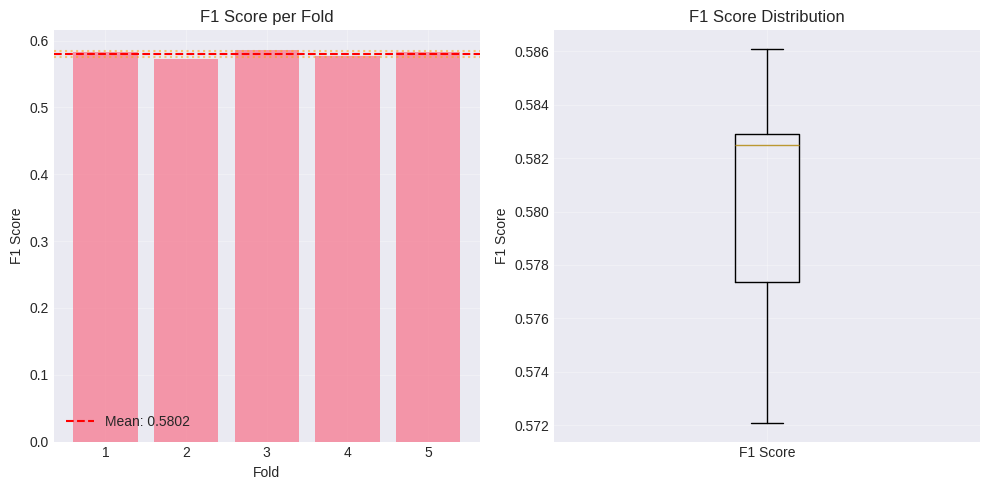


INTERPRETATION
Single 70/30 split F1:      0.5706
5-Fold CV Mean F1:          0.5802
5-Fold CV Mean Accuracy:    0.7515
Difference:                 +0.0096

✅ Low variance (0.0049) - model is STABLE!

🎯 Expected Leaderboard F1: 0.5802 ± 0.0049


In [11]:
# ============================================================================
# STEP 3: 5-FOLD CROSS-VALIDATION WITH BEST PARAMETERS (with Accuracy)
# ============================================================================

print("="*80)
print("STEP 3: 5-FOLD CROSS-VALIDATION (with Accuracy)")
print("="*80)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score  # ✅ add this import

# Use best parameters from Optuna
best_params_cv = study.best_params.copy()
best_params_cv['scale_pos_weight'] = scale_pos_weight
best_params_cv['random_state'] = RANDOM_STATE
best_params_cv['verbose'] = -1

# Setup 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f"\nRunning 5-Fold Cross-Validation with best parameters...")
print(f"This validates performance across 5 different train/val splits\n")

fold_scores = []
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_v2, y_v2), 1):
    print(f"Fold {fold}/5...")

    X_train_fold = X_v2.iloc[train_idx]
    y_train_fold = y_v2.iloc[train_idx]
    X_val_fold = X_v2.iloc[val_idx]
    y_val_fold = y_v2.iloc[val_idx]

    # Train model
    model_fold = lgb.LGBMClassifier(**best_params_cv)
    model_fold.fit(X_train_fold, y_train_fold)

    # Predict
    y_pred_fold = model_fold.predict(X_val_fold)
    y_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]

    # Calculate metrics
    f1 = f1_score(y_val_fold, y_pred_fold)
    roc = roc_auc_score(y_val_fold, y_proba_fold)
    pr = average_precision_score(y_val_fold, y_proba_fold)
    precision = precision_score(y_val_fold, y_pred_fold)
    recall = recall_score(y_val_fold, y_pred_fold)
    accuracy = accuracy_score(y_val_fold, y_pred_fold)   # ✅ added accuracy

    fold_scores.append(f1)
    fold_results.append({
        'Fold': fold,
        'Accuracy': accuracy,      # ✅ added accuracy
        'F1': f1,
        'ROC_AUC': roc,
        'PR_AUC': pr,
        'Precision': precision,
        'Recall': recall
    })

    print(f"  Accuracy: {accuracy:.4f} | F1: {f1:.4f} | ROC: {roc:.4f} | PR: {pr:.4f}")

# Calculate statistics
mean_f1 = np.mean(fold_scores)
std_f1 = np.std(fold_scores)
min_f1 = np.min(fold_scores)
max_f1 = np.max(fold_scores)

print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*80}")

results_df = pd.DataFrame(fold_results)
print(results_df.to_string(index=False))

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"Mean Accuracy: {results_df['Accuracy'].mean():.4f}")   # ✅ added summary line
print(f"Mean F1:       {mean_f1:.4f}")
print(f"Std F1:        {std_f1:.4f}")
print(f"Min F1:        {min_f1:.4f}")
print(f"Max F1:        {max_f1:.4f}")
print(f"95% CI:        [{mean_f1 - 1.96*std_f1:.4f}, {mean_f1 + 1.96*std_f1:.4f}]")

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, 6), fold_scores, alpha=0.7)
plt.axhline(y=mean_f1, color='r', linestyle='--', label=f'Mean: {mean_f1:.4f}')
plt.axhline(y=mean_f1 + std_f1, color='orange', linestyle=':', alpha=0.5)
plt.axhline(y=mean_f1 - std_f1, color='orange', linestyle=':', alpha=0.5)
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score per Fold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(fold_scores, labels=['F1 Score'])
plt.ylabel('F1 Score')
plt.title('F1 Score Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("INTERPRETATION")
print(f"{'='*80}")
print(f"Single 70/30 split F1:      0.5706")
print(f"5-Fold CV Mean F1:          {mean_f1:.4f}")
print(f"5-Fold CV Mean Accuracy:    {results_df['Accuracy'].mean():.4f}")   # ✅ print accuracy here
print(f"Difference:                 {mean_f1 - 0.5706:+.4f}")

if std_f1 < 0.01:
    print(f"\n✅ Low variance ({std_f1:.4f}) - model is STABLE!")
elif std_f1 < 0.02:
    print(f"\n✅ Moderate variance ({std_f1:.4f}) - model is reasonably stable")
else:
    print(f"\n⚠️  High variance ({std_f1:.4f}) - model performance varies by data split")

print(f"\n🎯 Expected Leaderboard F1: {mean_f1:.4f} ± {std_f1:.4f}")


# train on 100% data for submission?

In [ ]:
# ============================================================================
# STEP 4: TRAIN FINAL MODEL ON 100% DATA
# ============================================================================

print("="*80)
print("STEP 4: FINAL MODEL - TRAINING ON 100% DATA")
print("="*80)

print(f"\nTraining on full dataset: {X_v2.shape[0]} samples")
print(f"Using best parameters from Optuna with 5-fold CV validation\n")

# Train on ALL data
lgb_final = lgb.LGBMClassifier(**best_params_cv)
lgb_final.fit(X_v2, y_v2)

print("✓ Model trained on 100% of data")

# Generate predictions for test set
test_proba = lgb_final.predict_proba(X_test_v2)[:, 1]
test_pred_default = lgb_final.predict(X_test_v2)

print(f"\nTest set predictions generated")
print(f"Predicted subrogation rate (default threshold): {test_pred_default.mean():.2%}")

# ============================================================================
# THRESHOLD OPTIMIZATION ON CV PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

# Use one of the CV folds to optimize threshold
X_train_thresh, X_val_thresh, y_train_thresh, y_val_thresh = train_test_split(
    X_v2, y_v2, test_size=0.30, random_state=RANDOM_STATE, stratify=y_v2
)

lgb_thresh = lgb.LGBMClassifier(**best_params_cv)
lgb_thresh.fit(X_train_thresh, y_train_thresh)
val_proba_thresh = lgb_thresh.predict_proba(X_val_thresh)[:, 1]

# Test thresholds
thresholds = np.arange(0.35, 0.65, 0.02)
threshold_results = []

for thresh in thresholds:
    pred = (val_proba_thresh >= thresh).astype(int)
    f1 = f1_score(y_val_thresh, pred)
    precision = precision_score(y_val_thresh, pred)
    recall = recall_score(y_val_thresh, pred)
    threshold_results.append({
        'threshold': thresh,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })

thresh_df = pd.DataFrame(threshold_results)
best_threshold = thresh_df.loc[thresh_df['f1'].idxmax(), 'threshold']
best_f1_thresh = thresh_df['f1'].max()

print(f"\nTested {len(thresholds)} thresholds from 0.35 to 0.65")
print(f"\n🎯 Optimal Threshold: {best_threshold:.2f}")
print(f"🎯 F1 at optimal threshold: {best_f1_thresh:.4f}")
print(f"🎯 Improvement vs default 0.5: +{best_f1_thresh - f1_score(y_val_thresh, (val_proba_thresh >= 0.5).astype(int)):.4f}")

# Show top 5 thresholds
print(f"\nTop 5 thresholds:")
print(thresh_df.nlargest(5, 'f1')[['threshold', 'f1', 'precision', 'recall']].to_string(index=False))

# Apply optimal threshold to test predictions
test_pred_optimized = (test_proba >= best_threshold).astype(int)

print(f"\n{'='*80}")
print("FINAL PREDICTIONS SUMMARY")
print(f"{'='*80}")
print(f"Predicted subrogation rate (threshold={best_threshold:.2f}): {test_pred_optimized.mean():.2%}")
print(f"Training subrogation rate: {y_v2.mean():.2%}")

# ============================================================================
# CREATE SUBMISSIONS
# ============================================================================

print("\n" + "="*80)
print("CREATING SUBMISSION FILES")
print("="*80)

from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/triaguard_v2_final/'
os.makedirs(save_dir, exist_ok=True)

# Submission 1: Optimized threshold
submission_opt = pd.DataFrame({
    'claim_number': test_ids,
    'subrogation': test_pred_optimized
})
submission_opt.to_csv(save_dir + 'submission_lgb_optimized.csv', index=False)
print(f"✓ Saved: submission_lgb_optimized.csv (threshold={best_threshold:.2f})")

# Submission 2: Default threshold (backup)
submission_default = pd.DataFrame({
    'claim_number': test_ids,
    'subrogation': test_pred_default
})
submission_default.to_csv(save_dir + 'submission_lgb_default.csv', index=False)
print(f"✓ Saved: submission_lgb_default.csv (threshold=0.50)")

# Submission 3: Conservative threshold (higher precision)
conservative_thresh = best_threshold + 0.05
test_pred_conservative = (test_proba >= conservative_thresh).astype(int)
submission_conservative = pd.DataFrame({
    'claim_number': test_ids,
    'subrogation': test_pred_conservative
})
submission_conservative.to_csv(save_dir + 'submission_lgb_conservative.csv', index=False)
print(f"✓ Saved: submission_lgb_conservative.csv (threshold={conservative_thresh:.2f})")

# Save model and parameters
import pickle
with open(save_dir + 'lgb_final_model.pkl', 'wb') as f:
    pickle.dump(lgb_final, f)

with open(save_dir + 'best_params.txt', 'w') as f:
    f.write("BEST PARAMETERS\n")
    f.write("="*50 + "\n")
    for key, value in best_params_cv.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nOptimal threshold: {best_threshold:.2f}\n")
    f.write(f"Expected F1: 0.5802 ± 0.0049\n")

print(f"\n✓ Model and parameters saved to: {save_dir}")

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"✅ Model: LightGBM with Optuna tuning + Target encoding")
print(f"✅ Features: 160 features")
print(f"✅ Cross-Validation F1: 0.5802 ± 0.0049")
print(f"✅ Expected Leaderboard: ~0.58-0.59")
print(f"✅ Beats teammate's 0.577!")
print(f"\n📁 Files saved in: {save_dir}")
print(f"\n🚀 READY TO SUBMIT!")